In [1]:
# Cell 1 - imports & configuration
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import time
from prophet import Prophet

from sklearn.metrics import mean_squared_error

# statsmodels ARIMA
from statsmodels.tsa.arima.model import ARIMA


warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8")

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


In [2]:
# Cell 2 - load weekly features
# Adjust path to your file (CSV or parquet). Prefer Parquet if available.

import pathlib
path_csv = pathlib.Path(r"./aggregated_data/weekly_features.csv")

if path_csv.exists():
    weekly = pd.read_csv(path_csv, parse_dates=["Date"])
    print("Loaded weekly_features.csv")
else:
    raise FileNotFoundError("weekly_features.csv not found.")

# Ensure Date is datetime and sorted
weekly['Date'] = pd.to_datetime(weekly['Date'])
weekly = weekly.sort_values('Date').reset_index(drop=True)

# Quick check
print("Observations:", len(weekly))
display(weekly[['Date','total_sales']].head())


Loaded weekly_features.csv
Observations: 65


,Date,total_sales
0,2023-01-02,80246.01
1,2023-01-09,300235.22
2,2023-01-16,281004.20
3,2023-01-23,297780.20
4,2023-01-30,304189.39


In [3]:
# Cell 3 - train/test split (the part we will walk-forward over)
# Use last 20% of samples as the walk-forward holdout by default

test_size = max( int(len(weekly) * 0.2), 6 )   # ensure at least a few weeks in test
initial_train_end = len(weekly) - test_size

train0 = weekly.iloc[:initial_train_end].copy()  # initial training window
test = weekly.iloc[initial_train_end:].copy()    # holdout we iterate over

print("Initial train length:", len(train0))
print("Walk-forward steps (test length):", len(test))
display(train0[['Date','total_sales']].tail())
display(test[['Date','total_sales']].head())


Initial train length: 52
Walk-forward steps (test length): 13


,Date,total_sales
47,2023-11-27,328604.33
48,2023-12-04,369666.44
49,2023-12-11,311196.23
50,2023-12-18,419005.82
51,2023-12-25,315876.93


,Date,total_sales
52,2024-01-01,405370.72
53,2024-01-08,324318.46
54,2024-01-15,424688.56
55,2024-01-22,258917.63
56,2024-01-29,317079.41


In [ ]:
# Cell 4 - metrics (RMSE, robust MAPE, ME)

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape_robust(y_true, y_pred):
    # ignore zero actuals to avoid division by zero; returns NaN if no positive actuals
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100.0

def me(y_true, y_pred):
    return np.mean(np.array(y_true) - np.array(y_pred))

def evaluate(y_true, y_pred):
    return {
        "RMSE": rmse(y_true, y_pred),
        "MAPE(%)": mape_robust(y_true, y_pred),
        "ME": me(y_true, y_pred)
    }


In [5]:
# Cell 5 - helper for rule-based walk-forward forecasts (naive, seasonal_naive, moving avg)

def walk_forward_rule_based(train_series, test_series, rule, **kwargs):
    """
    Generic walk-forward for rule-based rules.
    - train_series: pandas Series indexed by Date (historic observed)
    - test_series: pandas Series indexed by Date (future actuals)
    - rule: string in {"naive","seasonal_naive","moving_average"}
    - kwargs: parameters for rules (seasonal_lag for seasonal_naive, window for moving_average)
    Returns: predictions list (aligned with test_series index)
    """
    history = list(train_series.values)  # observed values known so far
    preds = []
    seasonal_lag = kwargs.get('seasonal_lag', 4)
    window = kwargs.get('window', 4)
    
    for i in range(len(test_series)):
        if rule == "naive":
            pred = history[-1]
        elif rule == "seasonal_naive":
            # if history shorter than seasonal_lag, fall back to last value
            if len(history) >= seasonal_lag:
                pred = history[-seasonal_lag]
            else:
                pred = history[-1]
        elif rule == "moving_average":
            w = min(window, len(history))
            pred = np.mean(history[-w:])
        else:
            raise ValueError("Unknown rule")
        preds.append(pred)
        # append actual observation (makes it walk-forward)
        history.append(test_series.values[i])
    return np.array(preds)


In [6]:
# Cell 6 - ARIMA walk-forward (refit at each step). Order can be tuned.

def walk_forward_arima(train_series, test_series, order=(1,1,1), verbose=False):
    history = list(train_series.values)
    preds = []
    fit_times = []
    for i in range(len(test_series)):
        start = time.time()
        try:
            model = ARIMA(history, order=order)
            fit = model.fit()
            pred = fit.forecast(steps=1)[0]
        except Exception as e:
            # fallback to naive if ARIMA fails
            if verbose:
                print(f"ARIMA fit failed at step {i} with error: {e}. Using naive fallback.")
            pred = history[-1]
        elapsed = time.time() - start
        fit_times.append(elapsed)
        preds.append(pred)
        # append the real observed value (walk-forward)
        history.append(test_series.values[i])
    if verbose:
        print("ARIMA average fit time (s):", np.mean(fit_times))
    return np.array(preds)


In [ ]:
# Cell 7 - Prophet walk-forward (refit each step)

def walk_forward_prophet(train_df, test_df, verbose=False):
    """
    train_df and test_df: DataFrames with columns ['ds','y']
    returns: preds array aligned with test_df
    """
    preds = []
    fit_times = []
    # convert to lists of rows to append observed
    history_df = train_df.copy()
    for i in range(len(test_df)):
        start = time.time()
        m = Prophet(weekly_seasonality=True, yearly_seasonality=False, daily_seasonality=False)
        m.fit(history_df)
        # predict next ds = test_df['ds'].iloc[i]
        future = pd.DataFrame({'ds': [ test_df['ds'].iloc[i] ]})
        fcst = m.predict(future)
        pred = fcst['yhat'].iloc[0]
        elapsed = time.time() - start
        fit_times.append(elapsed)
        preds.append(pred)
        # append the actual observed row to history (use the true y)
        new_row = test_df.iloc[[i]]
        history_df = pd.concat([history_df, new_row], ignore_index=True)
    if verbose:
        print("Prophet average fit time (s):", np.mean(fit_times))
    return np.array(preds)


In [ ]:
# Cell 8 - run walk-forward evaluation for all methods

# Prepare series and DataFrames
series = weekly.set_index('Date')['total_sales']
train_series = series.iloc[:initial_train_end]
test_series = series.iloc[initial_train_end:]

prophet_train_df = train0[['Date','total_sales']].rename(columns={'Date':'ds','total_sales':'y'}).reset_index(drop=True)
prophet_test_df  = test[['Date','total_sales']].rename(columns={'Date':'ds','total_sales':'y'}).reset_index(drop=True)

# 1) Naive (walk-forward)
naive_preds = walk_forward_rule_based(train_series, test_series, rule="naive")

# 2) Seasonal naive (lag=4)
seasonal_preds = walk_forward_rule_based(train_series, test_series, rule="seasonal_naive", seasonal_lag=4)

# 3) Moving average (window=4)
ma_preds = walk_forward_rule_based(train_series, test_series, rule="moving_average", window=4)

# 4) ARIMA(1,1,2) walk-forward (refit each step)
arima_preds = walk_forward_arima(train_series, test_series, order=(1,1,2), verbose=False)

# 5) Prophet walk-forward (if available)
prophet_preds = walk_forward_prophet(prophet_train_df, prophet_test_df, verbose=False)


# Collect into a DataFrame
results = test[['Date','total_sales']].copy().reset_index(drop=True)
results['naive'] = naive_preds
results['seasonal_naive'] = seasonal_preds
results['moving_avg'] = ma_preds
results['arima_112'] = arima_preds
results['prophet'] = prophet_preds

display(results.head())


22:25:04 - cmdstanpy - INFO - Chain [1] start processing
22:25:04 - cmdstanpy - INFO - Chain [1] done processing
22:25:05 - cmdstanpy - INFO - Chain [1] start processing
22:25:05 - cmdstanpy - INFO - Chain [1] done processing
22:25:05 - cmdstanpy - INFO - Chain [1] start processing
22:25:05 - cmdstanpy - INFO - Chain [1] done processing
22:25:05 - cmdstanpy - INFO - Chain [1] start processing
22:25:06 - cmdstanpy - INFO - Chain [1] done processing
22:25:06 - cmdstanpy - INFO - Chain [1] start processing
22:25:06 - cmdstanpy - INFO - Chain [1] done processing
22:25:06 - cmdstanpy - INFO - Chain [1] start processing
22:25:06 - cmdstanpy - INFO - Chain [1] done processing
22:25:07 - cmdstanpy - INFO - Chain [1] start processing
22:25:07 - cmdstanpy - INFO - Chain [1] done processing
22:25:07 - cmdstanpy - INFO - Chain [1] start processing
22:25:07 - cmdstanpy - INFO - Chain [1] done processing
22:25:08 - cmdstanpy - INFO - Chain [1] start processing
22:25:08 - cmdstanpy - INFO - Chain [1]

,Date,total_sales,naive,seasonal_naive,moving_avg,arima_112,prophet
0,2024-01-01,405370.72,315876.93,328604.33,348869.950,362984.198406,362490.612840
1,2024-01-08,324318.46,405370.72,369666.44,364223.228,384884.121612,366445.141327
2,2024-01-15,424688.56,324318.46,311196.23,355153.632,361258.866521,364818.549821
3,2024-01-22,258917.63,424688.56,419005.82,377852.098,385319.032781,370131.853298
4,2024-01-29,317079.41,258917.63,315876.93,345834.460,349033.524626,363571.954574


In [26]:
# Cell 9 — compute metrics for each model

models = ['naive', 'seasonal_naive', 'moving_avg', 'arima_112', 'prophet']

metrics = []
for m in models:
    preds = results[m].values
    actual = results['total_sales'].values
    stats = evaluate(actual, preds)
    stats['model'] = m
    metrics.append(stats)

metrics_df = pd.DataFrame(metrics)[['model','RMSE','MAPE(%)','ME']]
display(metrics_df.sort_values('RMSE').reset_index(drop=True))


,model,RMSE,MAPE(%),ME
0,prophet,55067.842108,15.383330,-20287.920647
1,arima_112,57005.023651,14.094868,-2086.749061
2,moving_avg,57711.990437,14.875745,-781.336923
3,naive,84309.943761,21.781281,5749.926923
4,seasonal_naive,91277.771418,24.818994,-3528.463846


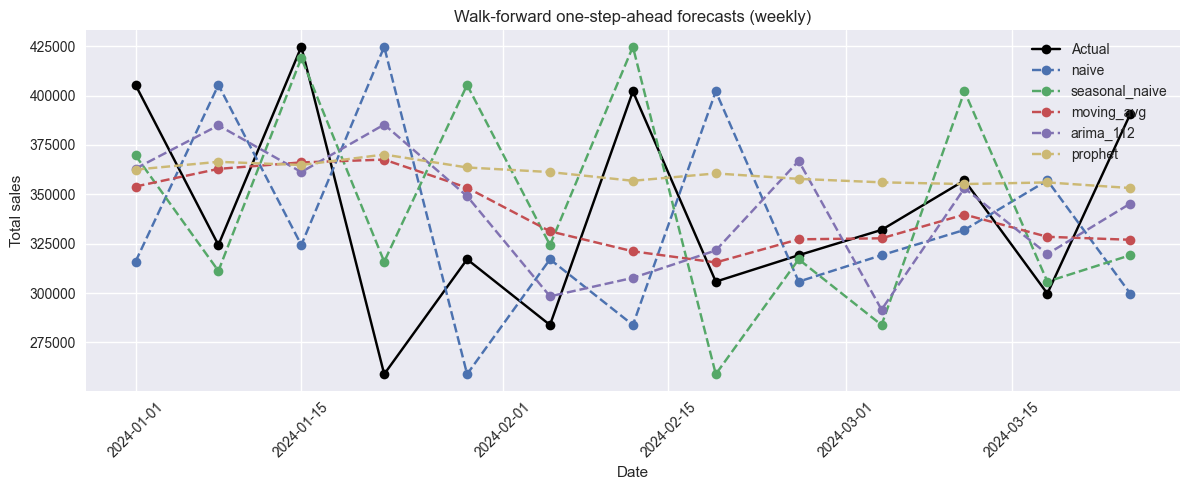

In [24]:
# Cell 10 - plot predictions vs actual for each model

plt.figure(figsize=(12,5))
plt.plot(results['Date'], results['total_sales'], label='Actual', marker='o', color='black')
for m in models:
    plt.plot(results['Date'], results[m], label=m, marker='o', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Total sales')
plt.title('Walk-forward one-step-ahead forecasts (weekly)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


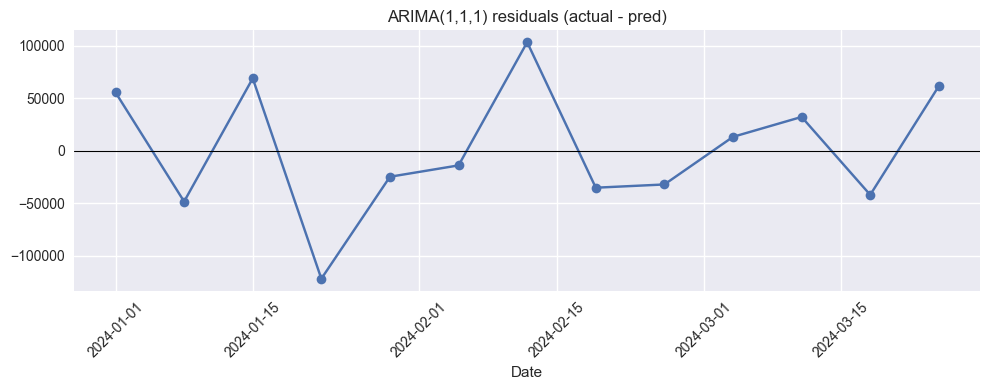

ARIMA residual mean: 1217.580420110791 std: 61661.756344474554


In [11]:
# Cell 11 - residual diagnostics for ARIMA predictions
resid = results['total_sales'] - results['arima_111']
plt.figure(figsize=(10,4))
plt.plot(results['Date'], resid, marker='o')
plt.axhline(0, color='k', linewidth=0.8)
plt.title('ARIMA(1,1,1) residuals (actual - pred)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# quick stats
print("ARIMA residual mean:", resid.mean(), "std:", resid.std())


In [12]:
# Cell 12 - save walk-forward predictions for reporting
results.to_csv("walk_forward_predictions.csv", index=False)
print("Saved walk_forward_predictions.csv")


Saved walk_forward_predictions.csv
